# Key Metrics to Track
1. Input Data Drift: Feature distribution changes (KS, PSI).

1. Concept Drift: Changes in feature-target relationship.

1. Prediction Drift: Shifts in model output distribution.

# Kolmogorov-Smirnov (KS) Test

Compares distributions of training vs. production data.

--- Monitoring feature1 (Numerical) ---
KS Statistic (No Drift): 0.070, P-value: 0.015, Drift Detected: True


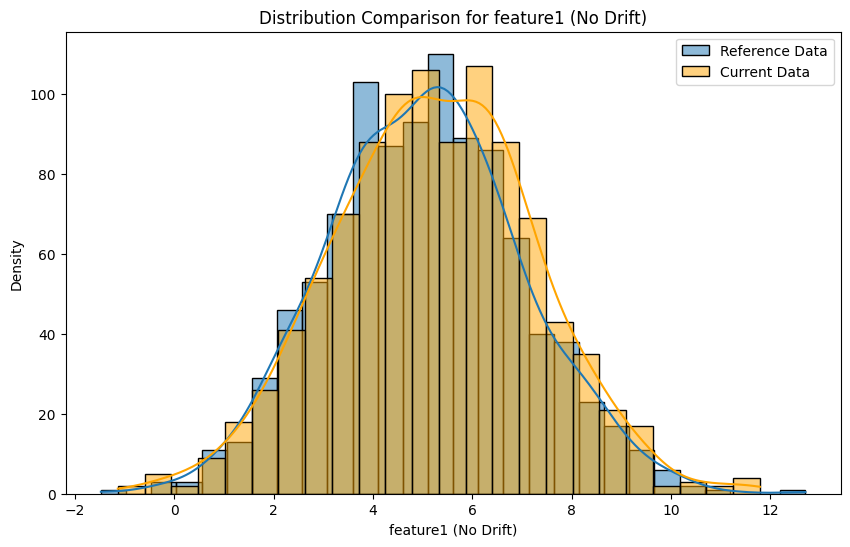


KS Statistic (Drift): 0.441, P-value: 0.000, Drift Detected: True


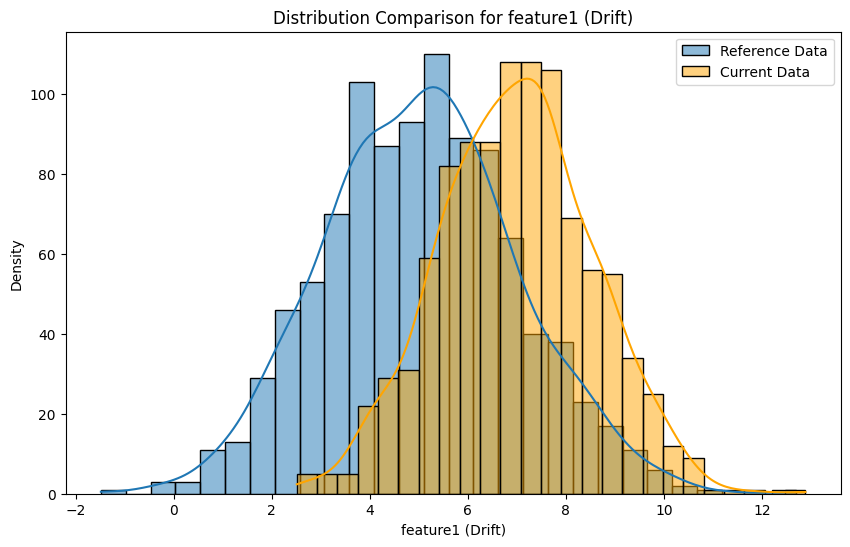


--- Monitoring feature2 (Categorical) ---

Chi-Squared Statistic (No Drift): 9.021, P-value: 0.011, Drift Detected: True
Reference Distribution (feature2):
 A    0.383
B    0.316
C    0.301
Name: feature2, dtype: float64
Current Distribution (feature2 - No Drift):
 A    0.425
B    0.279
C    0.296
Name: feature2, dtype: float64

Chi-Squared Statistic (Drift): inf, P-value: 0.000, Drift Detected: True
Reference Distribution (feature2):
 A    0.383
B    0.316
C    0.301
Name: feature2, dtype: float64
Current Distribution (feature2 - Drift):
 A    0.301
B    0.398
D    0.301
Name: feature2, dtype: float64


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:8064: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_ks_drift(reference_data: pd.Series, current_data: pd.Series, feature_name: str, threshold: float = 0.05):
    """
    Calculates the Kolmogorov-Smirnov (KS) statistic and p-value to detect drift
    between two numerical data distributions.

    Args:
        reference_data (pd.Series): The baseline data (e.g., training data).
        current_data (pd.Series): The new data to compare against the baseline.
        feature_name (str): The name of the feature being analyzed.
        threshold (float): The significance level (alpha) for the KS test. Drift is
                           suspected if the p-value is below this threshold.

    Returns:
        tuple: (ks_statistic, p_value, drift_detected)
    """
    ks_statistic, p_value = ks_2samp(reference_data, current_data)
    drift_detected = p_value < threshold
    return ks_statistic, p_value, drift_detected

def visualize_drift(reference_data: pd.Series, current_data: pd.Series, feature_name: str):
    """
    Visualizes the distributions of the reference and current data for a given feature.

    Args:
        reference_data (pd.Series): The baseline data.
        current_data (pd.Series): The new data.
        feature_name (str): The name of the feature.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(reference_data, label='Reference Data', kde=True)
    sns.histplot(current_data, color='orange', label='Current Data', kde=True)
    plt.title(f'Distribution Comparison for {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # Simulate reference (training) data
    np.random.seed(42)
    reference_feature1 = np.random.normal(loc=5, scale=2, size=1000)
    reference_feature2 = np.random.choice(['A', 'B', 'C'], size=1000, p=[0.4, 0.3, 0.3])
    reference_df = pd.DataFrame({'feature1': reference_feature1, 'feature2': reference_feature2})

    # Simulate current (incoming) data with potential drift
    current_feature1_no_drift = np.random.normal(loc=5.2, scale=2.1, size=1000)
    current_feature1_drift = np.random.normal(loc=7, scale=1.5, size=1000)
    current_feature2_no_drift = np.random.choice(['A', 'B', 'C'], size=1000, p=[0.42, 0.28, 0.30])
    current_feature2_drift = np.random.choice(['A', 'B', 'D'], size=1000, p=[0.3, 0.4, 0.3]) # Introducing a new category

    current_df_no_drift = pd.DataFrame({'feature1': current_feature1_no_drift, 'feature2': current_feature2_no_drift})
    current_df_drift_feature1 = pd.DataFrame({'feature1': current_feature1_drift, 'feature2': current_feature2_no_drift})
    current_df_drift_feature2 = pd.DataFrame({'feature1': current_feature1_no_drift, 'feature2': current_feature2_drift})

    print("--- Monitoring feature1 (Numerical) ---")
    # Case 1: No significant drift in feature1
    ks_stat_no_drift, p_val_no_drift, drift_no_drift = calculate_ks_drift(
        reference_df['feature1'], current_df_no_drift['feature1'], 'feature1'
    )
    print(f"KS Statistic (No Drift): {ks_stat_no_drift:.3f}, P-value: {p_val_no_drift:.3f}, Drift Detected: {drift_no_drift}")
    visualize_drift(reference_df['feature1'], current_df_no_drift['feature1'], 'feature1 (No Drift)')

    # Case 2: Significant drift in feature1
    ks_stat_drift, p_val_drift, drift = calculate_ks_drift(
        reference_df['feature1'], current_df_drift_feature1['feature1'], 'feature1'
    )
    print(f"\nKS Statistic (Drift): {ks_stat_drift:.3f}, P-value: {p_val_drift:.3f}, Drift Detected: {drift}")
    visualize_drift(reference_df['feature1'], current_df_drift_feature1['feature1'], 'feature1 (Drift)')

    print("\n--- Monitoring feature2 (Categorical) ---")
    # For categorical features, the KS test isn't directly applicable in the same way
    # as it relies on the empirical cumulative distribution function.
    # We can use other methods like Chi-Squared test or track category proportions.

    def calculate_chi2_drift(reference_data: pd.Series, current_data: pd.Series, feature_name: str, threshold: float = 0.05):
        """
        Calculates the Chi-Squared statistic and p-value to detect drift
        between two categorical data distributions.

        Args:
            reference_data (pd.Series): The baseline categorical data.
            current_data (pd.Series): The new categorical data.
            feature_name (str): The name of the feature.
            threshold (float): The significance level (alpha) for the Chi-Squared test.

        Returns:
            tuple: (chi2_statistic, p_value, drift_detected)
        """
        reference_counts = reference_data.value_counts()
        current_counts = current_data.value_counts()

        # Ensure both distributions have the same categories (handle new categories)
        all_categories = sorted(list(set(reference_counts.index) | set(current_counts.index)))
        observed = [current_counts.get(cat, 0) for cat in all_categories]
        expected_ref_probs = reference_counts / len(reference_data)
        expected = [expected_ref_probs.get(cat, 0) * len(current_data) for cat in all_categories]

        # Need at least two categories to perform the test
        if len(all_categories) < 2:
            return 0, 1.0, False # Cannot perform test

        from scipy.stats import chisquare
        chi2_statistic, p_value = chisquare(f_obs=observed, f_exp=expected)
        drift_detected = p_value < threshold
        return chi2_statistic, p_value, drift_detected

    # Case 3: No significant drift in feature2 (Categorical - using Chi-Squared approximation)
    chi2_stat_no_drift, p_val_chi2_no_drift, drift_chi2_no_drift = calculate_chi2_drift(
        reference_df['feature2'], current_df_no_drift['feature2'], 'feature2'
    )
    print(f"\nChi-Squared Statistic (No Drift): {chi2_stat_no_drift:.3f}, P-value: {p_val_chi2_no_drift:.3f}, Drift Detected: {drift_chi2_no_drift}")
    print("Reference Distribution (feature2):\n", reference_df['feature2'].value_counts(normalize=True).sort_index())
    print("Current Distribution (feature2 - No Drift):\n", current_df_no_drift['feature2'].value_counts(normalize=True).sort_index())

    # Case 4: Significant drift in feature2 (Categorical - using Chi-Squared approximation)
    chi2_stat_drift_cat, p_val_chi2_drift_cat, drift_chi2_cat = calculate_chi2_drift(
        reference_df['feature2'], current_df_drift_feature2['feature2'], 'feature2'
    )
    print(f"\nChi-Squared Statistic (Drift): {chi2_stat_drift_cat:.3f}, P-value: {p_val_chi2_drift_cat:.3f}, Drift Detected: {drift_chi2_cat}")
    print("Reference Distribution (feature2):\n", reference_df['feature2'].value_counts(normalize=True).sort_index())
    print("Current Distribution (feature2 - Drift):\n", current_df_drift_feature2['feature2'].value_counts(normalize=True).sort_index())

# Chi-Square Test
Checks for significant differences in categorical feature distributions.

In [ ]:
from scipy.stats import chi2_contingency
chi2, p, _, _ = chi2_contingency(observed_contingency_table)

# Classifier-Based Drift Detection

Train a classifier to distinguish between training and production data.

from sklearn.ensemble import RandomForestClassifier
import numpy as np

X_train = np.vstack([train_data, prod_data])
y_train = np.hstack([np.zeros(len(train_data)), np.ones(len(prod_data))])

clf = RandomForestClassifier().fit(X_train, y_train)
drift_score = clf.score(X_train, y_train)  # High score indicates drift

# Time-Series Drift Detection

Moving Averages & Control Charts. 
Track model performance over time

In [ ]:
import pandas as pd
df['ma_30'] = df['metric'].rolling(window=30).mean()

# CUSUM (Cumulative Sum) Control Chart

Detects small shifts in model behavior.

In [ ]:
from statsmodels.tsa.statespace.tools import cusum_squares
cusum_stats = cusum_squares(residuals)

# Alibi Detect (by Seldon)

Provides drift detection methods (KS, MMD, Chi-Square, etc.).

In [ ]:
from alibi_detect import KSDrift
drift_detector = KSDrift(train_data, p_val=0.05)
preds = drift_detector.predict(prod_data)

# Evidently AI

Monitors data and model drift with reports.

In [ ]:
from evidently.report import Report
from evidently.metrics import DatasetDriftMetric

report = Report(metrics=[DatasetDriftMetric()])
report.run(current_data=prod_data, reference_data=train_data)
report.show()

# River (for online drift detection)

Useful for streaming data.

In [ ]:
from river.drift import ADWIN
adwin = ADWIN()
for x in stream:
    adwin.update(x)
    if adwin.drift_detected:
        print("Drift detected!")

# NannyML
Estimates model performance without ground truth.

In [ ]:
import nannyml as nml
drift_calc = nml.UnivariateDriftCalculator(
    train_data, prod_data, feature_names=features
)
drift_results = drift_calc.calculate()

# Custom Monitoring (MLOps Tools)
## MLflow Tracking
Logs model performance over time.

## Weights & Biases (W&B)
Tracks model and data drift in dashboards.

## Amazon SageMaker Model Monitor
Built-in drift detection for deployed models.